<a name="software-requirements"></a>
# Software Requirements
This notebook requires the following libraries:
*   climate_learn (pip)

`climate_learn` contains the source files used for modeling climate extremes.

The package is written using `PyTorch` machine learning library.

In [1]:
%%bash
python -m pip install --upgrade pip
pip install git+https://github.com/aditya-grover/climate-learn.git@tutorials-split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/aditya-grover/climate-learn.git (to revision tutorials-split) to /tmp/pip-req-build-3wlye1dz
  Resolved https://github.com/aditya-grover/climate-learn.git to commit 197ce8bc4822de5b109052c0921d8168d8e1169e
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/aditya-grover/climate-learn.git /tmp/pip-req-build-3wlye1dz
  Running command git checkout -b tutorials-split --track origin/tutorials-split
  Switched to a new branch 'tutorials-split'
  Branch 'tutorials-split' set up to track remote branch 'tutorials-split' from 'origin'.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a name="temporal-forecasting"></a>
# Temporal Forecasting


A precise and reliable weather forecasting is of great importance in various aspect of society including precipitation forecasts are essential for agricultural needs, wind speed and solar power forecasts for energy generation.

<br>
<center><img src="https://drive.google.com/uc?export=view&id=1_tsaaogqzkYVV0jdawnO9GCJTToW_FCi" height=300></center>

The forecasting task can be categorized into (a) **nowcasting** (timescale of a few hours), (b) weather-scale prediction (typically 1day - 1week), (c) **seasonal** prediction (typically months) and (d) **multi-year or decadal** (timescale of multiple years).

In this tutorial, we shall focus on the **medium-range** weather-scale  prediction of the climate variables i.e., typically 3-5 days in the future. This colab notebook demonstrates the temporal forecasting of the *Temperature* variable at *2m* height above the earth's surface. This variable serves as a good indicator of future temperatures on the Earth's surface for the forecasters. 

We shall further use the 2m temperature data at 5.625 degree resolution that divides the Earth's surface into a latitude x longitude grid of 32 x 64.

<br/><br/>



**References:**
1. Rasp S, Dueben PD, Scher S, Weyn JA, Mouatadid S, Thuerey N. WeatherBench: a benchmark data set for data‐driven weather forecasting. Journal of Advances in Modeling Earth Systems. 2020 Nov;12(11):e2020MS002203 [(Paper)](https://arxiv.org/abs/2002.00469).
2. Civitarese DS, Szwarcman D, Zadrozny B, Watson C. Extreme Precipitation Seasonal Forecast Using a Transformer Neural Network. arXiv preprint arXiv:2107.06846. 2021 Jul 14. [(Paper)](https://arxiv.org/abs/2107.06846)
3. Sønderby CK, Espeholt L, Heek J, Dehghani M, Oliver A, Salimans T, Agrawal S, Hickey J, Kalchbrenner N. Metnet: A neural weather model for precipitation forecasting. arXiv preprint arXiv:2003.12140. 2020 Mar 24. [(Paper)](https://arxiv.org/pdf/2003.12140.pdf)


## Data Preparation

Check out the [Data Processing Notebook](https://github.com/aditya-grover/climate-learn/tree/main/docs/notebooks/Data_Processing) for more info on this part.

In [3]:
from climate_learn.data import download
from climate_learn.utils.data import load_dataset
from climate_learn.utils.datetime import Year, Days, Hours
from climate_learn.data import DataModule

# Download data from weatherbench (~2-3 minutes)
download(root = "/content/drive/MyDrive/Climate/.climate_tutorial", source = "weatherbench", variable = "2m_temperature", dataset = "era5", resolution = "5.625")
dataset = load_dataset("/content/drive/MyDrive/Climate/.climate_tutorial/data/weatherbench/era5/5.625/2m_temperature")

data_module = DataModule(
    dataset = "ERA5",
    task = "forecasting",
    root_dir = "/content/drive/MyDrive/Climate/.climate_tutorial/data/weatherbench/era5/5.625/",
    in_vars = ["2m_temperature"],
    out_vars = ["2m_temperature"],
    train_start_year = Year(2014),
    val_start_year = Year(2015),
    test_start_year = Year(2016),
    end_year = Year(2018),
    pred_range = Days(3),
    subsample = Hours(6),
    batch_size = 128,
    num_workers = 1
)

Creating train dataset


100%|██████████| 1/1 [00:00<00:00, 68.09it/s]


Creating val dataset


100%|██████████| 1/1 [00:00<00:00, 65.65it/s]


Creating test dataset


100%|██████████| 3/3 [00:00<00:00, 82.69it/s]


## Model Training & Evaluation

Check out the [Model notebook](https://github.com/aditya-grover/climate-learn/tree/main/docs/notebooks/Model_Training_&_Evaluation) for more info.

In [4]:
from climate_learn.models import load_model
from climate_learn.models import set_climatology

model_kwargs = {
    "in_channels": len(data_module.hparams.in_vars),
    "out_channels": len(data_module.hparams.out_vars),
    "n_blocks": 4
}

optim_kwargs = {
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "warmup_epochs": 1,
    "max_epochs": 5,
}

model_module = load_model(name = "resnet", task = "forecasting", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)
set_climatology(model_module, data_module)

### Training


In [5]:
from climate_learn.training import Trainer

trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    precision = 16,
    max_epochs = 5,
)

INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [6]:
from climate_learn.models import fit_lin_reg_baseline
fit_lin_reg_baseline(model_module, data_module, reg_hparam=0.0)

In [7]:
trainer.fit(model_module, data_module)

┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                       ┃ Type              ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ net                        │ ResNet            │  1.2 M │
│ 1  │ net.activation             │ LeakyReLU         │      0 │
│ 2  │ net.image_proj             │ PeriodicConv2D    │  6.4 K │
│ 3  │ net.image_proj.padding     │ PeriodicPadding2D │      0 │
│ 4  │ net.image_proj.conv        │ Conv2d            │  6.4 K │
│ 5  │ net.blocks                 │ ModuleList        │  1.2 M │
│ 6  │ net.blocks.0               │ ResidualBlock     │  295 K │
│ 7  │ net.blocks.0.activation    │ LeakyReLU         │      0 │
│ 8  │ net.blocks.0.conv1         │ PeriodicConv2D    │  147 K │
│ 9  │ net.blocks.0.conv1.padding │ PeriodicPadding2D │      0 │
│ 10 │ net.blocks.0.conv1.conv    │ Conv2d            │  147 K │
│ 11 │ net.blocks.0.conv2         │ PeriodicConv2D    │  147 K │
│ 12 │ net.blocks.0.conv2.padding │ PeriodicPadding2D │      0 │
│ 13 │ net.blocks.0.conv2.conv    │ Conv2d            │  147 K │
│ 14 │ net.blocks.0.shortcut      │ Identity          │      0 │
│ 15 │ net.blocks.0.norm1         │ BatchNorm2d       │    256 │
│ 16 │ net.blocks.0.norm2         │ BatchNorm2d       │    256 │
│ 17 │ net.blocks.0.drop          │ Dropout           │      0 │
│ 18 │ net.blocks.1               │ ResidualBlock     │  295 K │
│ 19 │ net.blocks.1.activation    │ LeakyReLU         │      0 │
│ 20 │ net.blocks.1.conv1         │ PeriodicConv2D    │  147 K │
│ 21 │ net.blocks.1.conv1.padding │ PeriodicPadding2D │      0 │
│ 22 │ net.blocks.1.conv1.conv    │ Conv2d            │  147 K │
│ 23 │ net.blocks.1.conv2         │ PeriodicConv2D    │  147 K │
│ 24 │ net.blocks.1.conv2.padding │ PeriodicPadding2D │      0 │
│ 25 │ net.blocks.1.conv2.conv    │ Conv2d            │  147 K │
│ 26 │ net.blocks.1.shortcut      │ Identity          │      0 │
│ 27 │ net.blocks.1.norm1         │ BatchNorm2d       │    256 │
│ 28 │ net.blocks.1.norm2         │ BatchNorm2d       │    256 │
│ 29 │ net.blocks.1.drop          │ Dropout           │      0 │
│ 30 │ net.blocks.2               │ ResidualBlock     │  295 K │
│ 31 │ net.blocks.2.activation    │ LeakyReLU         │      0 │
│ 32 │ net.blocks.2.conv1         │ PeriodicConv2D    │  147 K │
│ 33 │ net.blocks.2.conv1.padding │ PeriodicPadding2D │      0 │
│ 34 │ net.blocks.2.conv1.conv    │ Conv2d            │  147 K │
│ 35 │ net.blocks.2.conv2         │ PeriodicConv2D    │  147 K │
│ 36 │ net.blocks.2.conv2.padding │ PeriodicPadding2D │      0 │
│ 37 │ net.blocks.2.conv2.conv    │ Conv2d            │  147 K │
│ 38 │ net.blocks.2.shortcut      │ Identity          │      0 │
│ 39 │ net.blocks.2.norm1         │ BatchNorm2d       │    256 │
│ 40 │ net.blocks.2.norm2         │ BatchNorm2d       │    256 │
│ 41 │ net.blocks.2.drop          │ Dropout           │      0 │
│ 42 │ net.blocks.3               │ ResidualBlock     │  295 K │
│ 43 │ net.blocks.3.activation    │ LeakyReLU         │      0 │
│ 44 │ net.blocks.3.conv1         │ PeriodicConv2D    │  147 K │
│ 45 │ net.blocks.3.conv1.padding │ PeriodicPadding2D │      0 │
│ 46 │ net.blocks.3.conv1.conv    │ Conv2d            │  147 K │
│ 47 │ net.blocks.3.conv2         │ PeriodicConv2D    │  147 K │
│ 48 │ net.blocks.3.conv2.padding │ PeriodicPadding2D │      0 │
│ 49 │ net.blocks.3.conv2.conv    │ Conv2d            │  147 K │
│ 50 │ net.blocks.3.shortcut      │ Identity          │      0 │
│ 51 │ net.blocks.3.norm1         │ BatchNorm2d       │    256 │
│ 52 │ net.blocks.3.norm2         │ BatchNorm2d       │    256 │
│ 53 │ net.blocks.3.drop          │ Dropout           │      0 │
│ 54 │ net.norm                   │ BatchNorm2d       │    256 │
│ 55 │ net.final                  │ PeriodicConv2D    │  6.3 K │
│ 56 │ net.final.padding          │ PeriodicPadding2D │      0 │
│ 57 │ net.final.conv             │ Conv2d            │  6.3 K │
│ 58 │ denormalization            │

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 2

Output()

### Evaluation 

The model's prediction has a strong correlation with the ground truth, which is indicated by a high ACC value. Compared to a climatological forecast, the deep learning model achieves a much smaller RMSE error.

In [8]:
trainer.test(model_module, data_module)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│             test/acc_2m_temperature_day_3              │                   0.8108727510088519                   │
│            test/w_rmse_2m_temperature_day_3            │                   3.0871731455287192                   │
│ test_climatology_baseline/w_rmse_2m_temperature_day_3  │                   5.859798067678751                    │
│ test_persistence_baseline/w_rmse_2m_temperature_day_3  │                   3.2076813060154206                   │
│ test_ridge_regression_baseline/w_rmse_2m_temperature_… │                   3.293193058790369                    │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

## Visualization 

We visualize the **bias**, given by the difference in the predicted and the ground truth values, to better analyze our learned model.

Visualization is done on the test set. We can either specify exact time for the initial condition, or randomly sample from the test set.

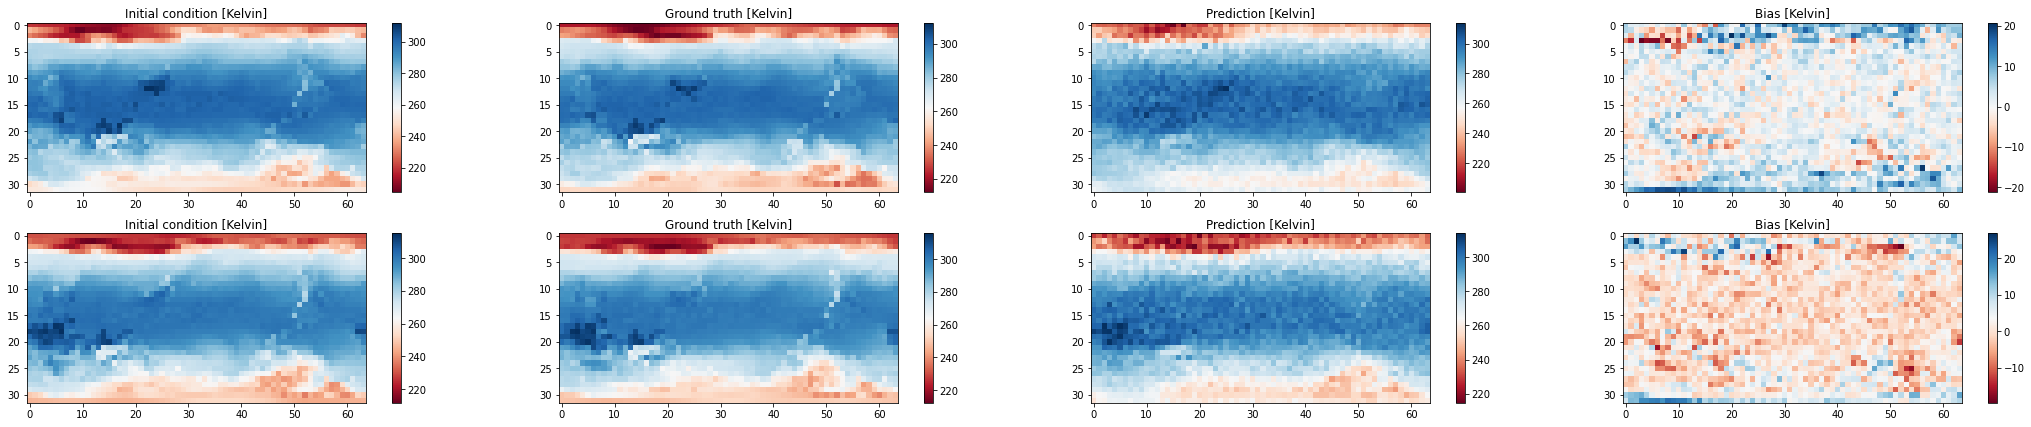

In [9]:
from climate_learn.utils import visualize

# if samples = 2, we randomly pick 2 initial conditions in the test set
visualize(model_module, data_module, samples = ["2017-06-01:12", "2017-08-01:18"])

The visualization shows that the model makes reasonably accurate predictions in most parts of the globe, and the prediction well correlates with the ground truth. The model seems to make large errors near the two poles, where the temperature is more unpredictable. We can improve the accuracy of the model by either including more input variables, using a more expressive model, or training for longer. For the sake of this tutorial, we use a small model and only train for a short time.

In addition to visualizing the bias the model makes for each individual data point, we can also visualize the mean bias across the entire test set.

100%|██████████| 205/205 [00:59<00:00,  3.44it/s]


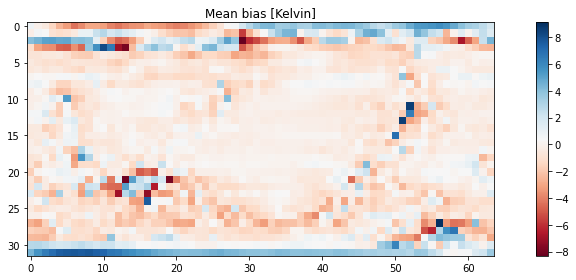

In [10]:
from climate_learn.utils import visualize_mean_bias
visualize_mean_bias(model_module.cuda(), data_module)

<a name="spatial-downscaling"></a>
# Spatial Downscaling


General Circulation Models (GCMs) provide us with the future projections of climate scenarios. These raw estimates have to be downscaled at the desired resolution for actionable guidance.

<br>
<center><img src="https://drive.google.com/uc?export=view&id=11i2CIRxlVRqOHIgZRABwF05Qf5KeqVwc" height=300></center>

In practice, statistical spatial downscaling can be used to make predictions about a climate variable (a) over the latitude-longitude grid of **higher** resolution than the input grid and (b) on specific sites at the target locations. For example, we can predict the temperature at a specific station in Germany based on the gridded temperature data over the whole country.

Major class of statistical downscaling models include Perfect Prognosis (PP) [1] that aims at learning a transfer function $$\hat{y} = f(x, Z)$$ where $y$ is the true value at location $x$ and $Z$ are the set of model predictors for the climate model. The various PP models differ in their realization of the transfer function $f$. Related works in [2] provides deeper details into the previous works. In [2,3], the authors use CNNs as the transfer function, broadly due to its inherent inductive bias towards handling Vision data. The ability of Deep CNNs to perform super-resolution is a well-explored field of study [4].

<br/><br/>

**References:**
1. Maraun D, Wetterhall F, Ireson AM, Chandler RE, Kendon EJ, Widmann M, Brienen S, Rust HW, Sauter T, Themeßl M, Venema VK. Precipitation downscaling under climate change: Recent developments to bridge the gap between dynamical models and the end user. Reviews of geophysics. 2010 Sep;48(3).
2. Vaughan A, Tebbutt W, Hosking JS, Turner RE. Convolutional conditional neural processes for local climate downscaling. arXiv preprint arXiv:2101.07950. 2021 Jan 20.
3. Baño-Medina J, Manzanas R, Gutiérrez JM. Configuration and intercomparison of deep learning neural models for statistical downscaling. Geoscientific Model Development. 2020 Apr 28;13(4):2109-24.
4. Yamanaka J, Kuwashima S, Kurita T. Fast and accurate image super resolution by deep CNN with skip connection and network in network. InInternational Conference on Neural Information Processing 2017 Nov 14 (pp. 217-225). Springer, Cham.

- In this tutorial, we shall focus on mapping the coarse resolution data for a variable to a finer resolution at a given time stamp. Specifically, we shall continue with focusing on the _Temperature at 2m_ climate variable using a ResNet model.

## Data Preparation

To perfrom climate downscaling, we need to have data for the temperature at 2m at different resolutions. In addition to the 5.625deg dataset we downloaded above, here we download the 2.8125deg dataset, which divides the Earth's surface into a latitude x longitude grid of 64 x 128.

In [11]:
from climate_learn.data import download
from climate_learn.utils.datetime import Year, Days, Hours
from climate_learn.data import DataModule

# Download data from weatherbench (~4-6 minutes)
download(root = "/content/drive/MyDrive/Climate/.climate_tutorial", source = "weatherbench", variable = "2m_temperature", dataset = "era5", resolution = "2.8125")

data_module = DataModule(
    dataset = "ERA5",
    task = "downscaling",
    root_dir = "/content/drive/MyDrive/Climate/.climate_tutorial/data/weatherbench/era5/5.625",
    root_highres_dir = "/content/drive/MyDrive/Climate/.climate_tutorial/data/weatherbench/era5/2.8125",
    in_vars = ["2m_temperature"],
    out_vars = ["2m_temperature"],
    train_start_year = Year(2014),
    val_start_year = Year(2015),
    test_start_year = Year(2016),
    end_year = Year(2018),
    subsample = Hours(6),
    batch_size = 128,
    num_workers = 1
)

Creating train dataset


100%|██████████| 1/1 [00:03<00:00,  3.00s/it]


Creating val dataset


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Creating test dataset


100%|██████████| 3/3 [00:08<00:00,  2.76s/it]


## Model Training & Evaluation 

In [12]:
from climate_learn.models import load_model

model_kwargs = {
    "in_channels": len(data_module.hparams.in_vars),
    "out_channels": len(data_module.hparams.out_vars),
    "n_blocks": 4,
}

optim_kwargs = {
    "optimizer": "adamw",
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "warmup_epochs": 1,
    "max_epochs": 5,
}

model_module = load_model(name = "resnet", task = "downscaling", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)

In [13]:
# latitude long info, 
from climate_learn.models import set_climatology
set_climatology(model_module, data_module)

### Training

In [14]:
from climate_learn.training import Trainer

trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    precision = 16,
    max_epochs = 5,
)

INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [15]:
trainer.fit(model_module, data_module)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                       ┃ Type              ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ net                        │ ResNet            │  1.2 M │
│ 1  │ net.activation             │ LeakyReLU         │      0 │
│ 2  │ net.image_proj             │ PeriodicConv2D    │  6.4 K │
│ 3  │ net.image_proj.padding     │ PeriodicPadding2D │      0 │
│ 4  │ net.image_proj.conv        │ Conv2d            │  6.4 K │
│ 5  │ net.blocks                 │ ModuleList        │  1.2 M │
│ 6  │ net.blocks.0               │ ResidualBlock     │  295 K │
│ 7  │ net.blocks.0.activation    │ LeakyReLU         │      0 │
│ 8  │ net.blocks.0.conv1         │ PeriodicConv2D    │  147 K │
│ 9  │ net.blocks.0.conv1.padding │ PeriodicPadding2D │      0 │
│ 10 │ net.blocks.0.conv1.conv    │ Conv2d            │  147 K │
│ 11 │ net.blocks.0.conv2         │ PeriodicConv2D    │  147 K │
│ 12 │ net.blocks.0.conv2.padding │ PeriodicPadding2D │      0 │
│ 13 │ net.blocks.0.conv2.conv    │ Conv2d            │  147 K │
│ 14 │ net.blocks.0.shortcut      │ Identity          │      0 │
│ 15 │ net.blocks.0.norm1         │ BatchNorm2d       │    256 │
│ 16 │ net.blocks.0.norm2         │ BatchNorm2d       │    256 │
│ 17 │ net.blocks.0.drop          │ Dropout           │      0 │
│ 18 │ net.blocks.1               │ ResidualBlock     │  295 K │
│ 19 │ net.blocks.1.activation    │ LeakyReLU         │      0 │
│ 20 │ net.blocks.1.conv1         │ PeriodicConv2D    │  147 K │
│ 21 │ net.blocks.1.conv1.padding │ PeriodicPadding2D │      0 │
│ 22 │ net.blocks.1.conv1.conv    │ Conv2d            │  147 K │
│ 23 │ net.blocks.1.conv2         │ PeriodicConv2D    │  147 K │
│ 24 │ net.blocks.1.conv2.padding │ PeriodicPadding2D │      0 │
│ 25 │ net.blocks.1.conv2.conv    │ Conv2d            │  147 K │
│ 26 │ net.blocks.1.shortcut      │ Identity          │      0 │
│ 27 │ net.blocks.1.norm1         │ BatchNorm2d       │    256 │
│ 28 │ net.blocks.1.norm2         │ BatchNorm2d       │    256 │
│ 29 │ net.blocks.1.drop          │ Dropout           │      0 │
│ 30 │ net.blocks.2               │ ResidualBlock     │  295 K │
│ 31 │ net.blocks.2.activation    │ LeakyReLU         │      0 │
│ 32 │ net.blocks.2.conv1         │ PeriodicConv2D    │  147 K │
│ 33 │ net.blocks.2.conv1.padding │ PeriodicPadding2D │      0 │
│ 34 │ net.blocks.2.conv1.conv    │ Conv2d            │  147 K │
│ 35 │ net.blocks.2.conv2         │ PeriodicConv2D    │  147 K │
│ 36 │ net.blocks.2.conv2.padding │ PeriodicPadding2D │      0 │
│ 37 │ net.blocks.2.conv2.conv    │ Conv2d            │  147 K │
│ 38 │ net.blocks.2.shortcut      │ Identity          │      0 │
│ 39 │ net.blocks.2.norm1         │ BatchNorm2d       │    256 │
│ 40 │ net.blocks.2.norm2         │ BatchNorm2d       │    256 │
│ 41 │ net.blocks.2.drop          │ Dropout           │      0 │
│ 42 │ net.blocks.3               │ ResidualBlock     │  295 K │
│ 43 │ net.blocks.3.activation    │ LeakyReLU         │      0 │
│ 44 │ net.blocks.3.conv1         │ PeriodicConv2D    │  147 K │
│ 45 │ net.blocks.3.conv1.padding │ PeriodicPadding2D │      0 │
│ 46 │ net.blocks.3.conv1.conv    │ Conv2d            │  147 K │
│ 47 │ net.blocks.3.conv2         │ PeriodicConv2D    │  147 K │
│ 48 │ net.blocks.3.conv2.padding │ PeriodicPadding2D │      0 │
│ 49 │ net.blocks.3.conv2.conv    │ Conv2d            │  147 K │
│ 50 │ net.blocks.3.shortcut      │ Identity          │      0 │
│ 51 │ net.blocks.3.norm1         │ BatchNorm2d       │    256 │
│ 52 │ net.blocks.3.norm2         │ BatchNorm2d       │    256 │
│ 53 │ net.blocks.3.drop          │ Dropout           │      0 │
│ 54 │ net.norm                   │ BatchNorm2d       │    256 │
│ 55 │ net.final                  │ PeriodicConv2D    │  6.3 K │
│ 56 │ net.final.padding          │ PeriodicPadding2D │      0 │
│ 57 │ net.final.conv             │ Conv2d            │  6.3 K │
│ 58 │ denormalization            │

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 2

Output()

### Evaluation

In [16]:
trainer.test(model_module, data_module)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test/mean_bias_2m_temperature │      -0.7963107824325562      │
│ test/pearsonr_2m_temperature  │      0.9912776310847699       │
│   test/rmse_2m_temperature    │      2.8612732887268066       │
└───────────────────────────────┴───────────────────────────────┘

## Visualization 

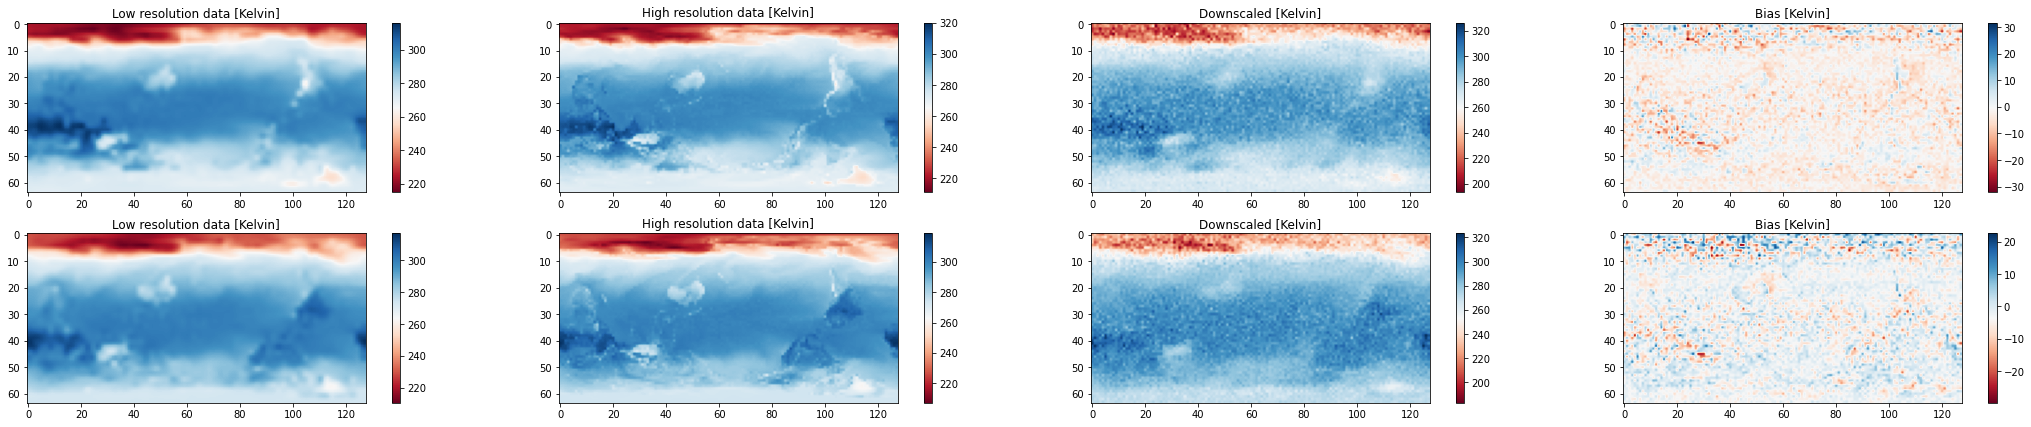

In [17]:
visualize(model_module, data_module, samples = ["2017-06-01:12", "2017-08-01:18"])